In [74]:
#All The Imports needed to run the Application
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import sklearn
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import os

In [63]:
#Set The parameters
num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 16

#Defining The directories of The Data Location
train_data_dir = './fruits-360/train'
validation_data_dir = './fruits-360/validation'

#Select the TrainDatagenerator to Generate Specifics we need for Image
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
#Generate The Training And Testing Data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


In [65]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_57 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 64)      

In [68]:
#Training The model for Accuracy

#Creating A Checkpoint variable for passing it into the Callbacks
checkpoint = ModelCheckpoint("./fruits_fresh_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

#Creating Early Stopping variable for passing it into Callbacks
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

#Creating LR for stopping while the loss is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

#Defining Callbacks as a list
callbacks = [checkpoint, earlystopping, reduce_lr]

#Compile the model, Using RMS prop as optimizer you can tweak this by using Adam and different Optimizers like SGD
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

#Define Variables for Train and Test Samples
#For Example when you wanted to see the train samples go up and check the notebook to find the train samples.

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 10

#Store everything in History to See graph of the performance 
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/10
2582/2582 [==============================] - ETA: 0s - loss: 1.3372 - accuracy: 0.5721
Epoch 00001: val_loss improved from inf to 0.66867, saving model to .\fruits_fresh_cnn_1.h5
2582/2582 [==============================] - 175s 68ms/step - loss: 1.3372 - accuracy: 0.5721 - val_loss: 0.6687 - val_accuracy: 0.7880
Epoch 2/10
2582/2582 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.8134
Epoch 00002: val_loss improved from 0.66867 to 0.29773, saving model to .\fruits_fresh_cnn_1.h5
2582/2582 [==============================] - 176s 68ms/step - loss: 0.5854 - accuracy: 0.8134 - val_loss: 0.2977 - val_accuracy: 0.9033
Epoch 3/10
2582/2582 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.8574
Epoch 00003: val_loss did not improve from 0.29773
2582/2582 [==============================] - 193s 75ms/step - loss: 0.4768 - accuracy: 0.8574 - val_loss: 0.3797 - val_accuracy: 0.8889
Epoch 4/10
2582/2582 [==============================] - ETA

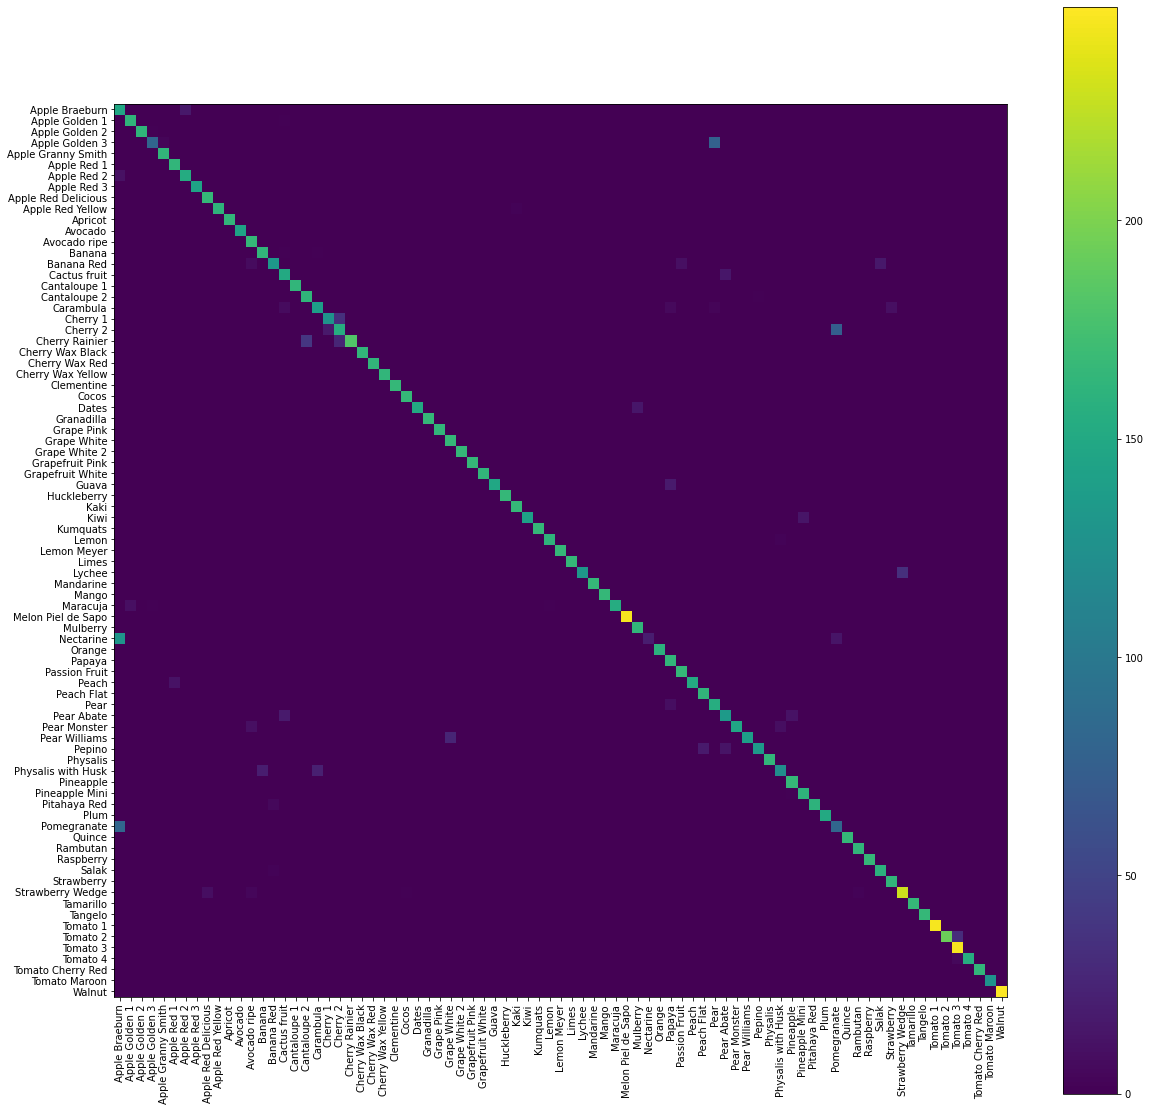

In [71]:
img_row, img_height, img_depth = 32,32,3
model = load_model('./fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 41322
nb_validation_samples = 13877

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [73]:
#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[148   0   0 ...   0   0   0]
 [  0 163   0 ...   0   0   0]
 [  0   0 163 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0 249]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.40      0.90      0.55       164
     Apple Golden 1       0.94      0.99      0.97       164
     Apple Golden 2       1.00      0.99      1.00       164
     Apple Golden 3       0.98      0.50      0.66       161
 Apple Granny Smith       0.98      1.00      0.99       164
        Apple Red 1       0.93      1.00      0.96       164
        Apple Red 2       0.91      0.93      0.92       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       0.95      1.00      0.97       166
   Apple Red Yellow       1.00      0.99      0.99       164
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      

In [ ]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './fruits-360/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()